In [11]:
import itertools
import operator
import sys

sys.path.append("../src")

import os
import numpy as np
from tqdm.notebook import tqdm
from neuraldb.scoring.r_precision import f1
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt

In [4]:
search_root = "/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator"
checkpoint_name = "metrics_test.jsonl"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)

print(len(files))

1468


In [5]:

def expand(idx,chunk):
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]

  return []

experiments = []
for file in files:
    chunks = file.split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data['dir'] = os.path.dirname(file)
    data["train_percentage"] = float(data["train_percentage"])*100 if data["train_percentage"] != "null" else 100.0
    if "clean" in file and "noisy" in file:
        print(file)
    if data["version"].startswith("v1.3"):
        experiments.append(data)

print(len(experiments))

/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator_sweep/dataset=operator,model=t5-base,version=v2.2_clean_noisy/lr=8e-5/filters=null,train_percentage=1.0/seed-1/metrics_test.jsonl
/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator_sweep/dataset=operator,model=t5-base,version=v2.2_clean_noisy/lr=8e-5/filters=null,train_percentage=1.0/seed-2/metrics_test.jsonl
/checkpoint/jth/job_staging/neuraldb_expts/experiment=operator_sweep/dataset=operator,model=t5-base,version=v2.2_clean_noisy/lr=8e-5/filters=null,train_percentage=1.0/seed-3/metrics_test.jsonl
372


In [6]:
from collections import defaultdict


for experiment in tqdm(experiments):
    all_raw = []
    all_breakdown = defaultdict(dict)
    em = 0.0
    with open(experiment['file']) as f:
        for line in f:
            partial_results = json.loads(line)
            all_raw.extend(partial_results['test']['raw'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["breakdown_prop"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["breakdown_type"].items())


    experiment["EM"] = np.mean([rec[2] for rec in all_raw])

    for k,v in all_breakdown["breakdown_prop"].items():
        experiment["prop_{}".format(k)] = np.mean(v)

    for k,v in all_breakdown["breakdown_type"].items():
        experiment["type_{}".format(k)] = np.mean(v)
        experiment["count_type_{}".format(k)] = len(v)


    experiment["raw"] = all_raw

    qt = set()
    at = set()
    

    avg = []
    for k,v in experiment.items():
        if k.startswith("type_negative"):
            avg.append((experiment["count_{}".format(k)], v))

    support, ems = zip(*avg)
    experiment["x_avg_negative"] = np.average(a=ems,weights=support)


    gold = defaultdict(lambda: defaultdict(list))
    for instance in experiment["raw"]:
        qt.add(instance[3]["query"])
        at.update(instance[3]["fact"])

        if instance[0] != "[NULL_ANSWER]" or instance[1] != "[NULL_ANSWER]":

            gold[instance[3]["type"]][instance[3]["query"]].append((instance[0], instance[1]))

    print(len(qt),len(at))
    aem = 0
    aem_count = 0

    scores = defaultdict(int)
    counts = defaultdict(int)

    maxen = set()
    mc100 = 0
    cc100 =0
    for t, questions in gold.items():
        
        if t in {"atomic_boolean","join_boolean", "atomic_extractive","join_extractive"}:
            for question, answers in questions.items():
                for answer in answers:
                    aem_count +=1
                    counts[t] += 1

                    if answer[0] == answer[1]:
                        aem += 1
                        scores[t]+=1
        elif t == "argmin":

            for question, answers in questions.items():
                maxen.add(len(answers))
                argmin_aggr_gold = defaultdict(list)
                argmin_aggr_pred = defaultdict(list)
                for answer in answers:
                    if answer[0] != "[NULL_ANSWER]" and "[SEP]" in answer[0]:
                        key,value = answer[0].split("[SEP]",maxsplit=1)
                        argmin_aggr_pred[key.strip()] = value.strip()

                    if answer[1] != "[NULL_ANSWER]":
                        key,value = answer[1].split("[SEP]",maxsplit=1)
                        argmin_aggr_gold[key.strip()] = value.strip()

                min_item_gold = sorted(argmin_aggr_gold.items(),key=lambda item: len(item[1]))
                min_item_pred = sorted(argmin_aggr_pred.items(),key=lambda item: len(item[1]))

                aem_count +=1
                counts[t] +=1
                if len(min_item_pred):
                    if min_item_gold[0][0] == min_item_pred[0][0]:
                        scores[t]+=1
                        aem+=1

                    if len(answers) > 100:
                        mc100+= 1 if min_item_gold[0][0] == min_item_pred[0][0] else 0
                        cc100+=1

        elif t == "argmax":

            for question, answers in questions.items():
                maxen.add(len(answers))
                argmin_aggr_gold = defaultdict(list)
                argmin_aggr_pred = defaultdict(list)
                for answer in answers:
                    if answer[0] != "[NULL_ANSWER]" and "[SEP]" in answer[0]:
                        key,value = answer[0].split("[SEP]",maxsplit=1)
                        argmin_aggr_pred[key.strip()] = value.strip()

                    if answer[1] != "[NULL_ANSWER]":
                        key,value = answer[1].split("[SEP]",maxsplit=1)
                        argmin_aggr_gold[key.strip()] = value.strip()

                min_item_gold = sorted(argmin_aggr_gold.items(),key=lambda item: len(item[1]),reverse=True)
                min_item_pred = sorted(argmin_aggr_pred.items(),key=lambda item: len(item[1]),reverse=True)

                aem_count +=1
                counts[t] +=1
                if len(min_item_pred):
                    if min_item_gold[0][0] == min_item_pred[0][0]:
                        aem+=1
                        scores[t]+=1

                    if len(answers) > 100:
                        mc100+= 1 if min_item_gold[0][0] == min_item_pred[0][0] else 0
                        cc100+=1

        elif t == "set":

            for question, answers in questions.items():
                maxen.add(len(answers))
                set_gold = set()
                set_pred = set()
                for answer in answers:
                    if answer[0] != "[NULL_ANSWER]":
                        set_pred.add(answer[0].strip())

                    if answer[1] != "[NULL_ANSWER]":
                        set_gold.add(answer[1].strip())

                aem_count +=1
                counts[t] +=1
                aem += f1(set_gold, set_pred)
                scores[t] += f1(set_gold, set_pred)

                if len(answers) > 100:
                    mc100+= f1(set_gold, set_pred)
                    cc100+=1

        elif t == "count":
            for question, answers in questions.items():
                maxen.add(len(answers))
                if len(answers) > 100:
                    mc100+=1
                    cc100+=1
                set_gold = set()
                set_pred = set()
                for answer in answers:
                    if answer[0] != "[NULL_ANSWER]":
                        set_pred.add(answer[0].strip())

                    if answer[1] != "[NULL_ANSWER]":
                        set_gold.add(answer[1].strip())

                aem_count +=1
                aem += 1 if len(set_gold) == len(set_pred) else 0
                scores[t] += 1 if len(set_gold) == len(set_pred) else 0
                counts[t] += 1

                if len(answers) > 100:
                    mc100+= 1 if len(set_gold) == len(set_pred) else 0
                    cc100+=1


    #print(experiment["file"],mc100/cc100)
    #print(sorted(list(maxen),reverse=True)[:25])
    for k,v in counts.items():
        experiment["A_type_{}".format(k)] = scores[k]/v
        experiment["A_type_strict_{}".format(k)] = scores[k]/v

    experiment["A_EM"] =aem/aem_count

17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
17204 169
20578 169
20578 169
20578 169
20578 169


In [7]:
results = pd.DataFrame(experiments).fillna(0)

cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "A_EM" or col == "EM" or col.startswith("x_") or col.startswith("prop_") or col.startswith("type_"),results.columns)}
cols.update({col:[np.max] for col in filter(lambda col: col.startswith("count_type_negative"), results.columns)})
breakdown_cols = list(filter(lambda col: col.startswith("prop_"),results.columns))
type_cols = list(filter(lambda col: (col.startswith("type_") and "negative" not in col) or col.startswith("x"),results.columns))
print(type_cols)
type_cols2 = list(filter(lambda col: col.startswith("type_") and "negative" not in col or col == "x_avg_negative",results.columns))
a_type_cols = list(filter(lambda col: col.startswith("A_type_") and "negative" not in col or col == "x_avg_negative",results.columns))
type_cols3 = list(filter(lambda col: "count" not in col and  "negative" in col,results.columns))
type_cols4 = list(filter(lambda col: col.startswith("type_") and "negative" not in col,results.columns))
breakdown = pd.pivot_table(results, index=["experiment","version","model","lr","filters","train_percentage"],columns=[],aggfunc=cols)
#pd.option_context("display.max_rows",None)
pd.options.display.max_rows = 150
breakdown

['type_bool', 'type_set', 'type_argmax', 'type_argmin', 'type_count', 'x_avg_negative']


A_EM  \
                                                                   mean   
experiment      version model   lr   filters train_percentage             
operator_filter v1.3.2  t5-base 8e-5 P106    100.0             0.754970   
                                     P108    100.0             0.953100   
                                     P1082   100.0             0.942811   
                                     P1092   100.0             0.952921   
                                     P1110   100.0             0.954959   
                                     P1174   100.0             0.952633   
                                     P118    100.0             0.954618   
                                     P1198   100.0             0.953627   
                                     P1867   100.0             0.955196   
                                     P19     100.0             0.945102   
                                     P19.P20 100.0             0.933198   
                                     P20     100.0             0.951906   
                                     P21     100.0             0.948298   
                                     P22     100.0             0.955194   
                                     P22.P23 100.0             0.951885   
                                     P23     100.0             0.955052   
                                     P26     100.0             0.952943   
                                     P27     100.0             0.928584   
                                     P35     100.0             0.954482   
                                     P38     100.0             0.955286   
                                     P47     100.0             0.927121   
                                     P50     100.0             0.954126   
                                     P54     100.0             0.946459   
                                     P57     100.0             0.952945   
                                     P58     100.0             0.954301   
                                     P6      100.0             0.954104   
                                     P61     100.0             0.950638   
                                     P69     100.0             0.949984   
operator_sweep  v1.3.1  t5-base 1e-6 null    1.0               0.380243   
                                             2.5               0.380874   
                                             5.0               0.382641   
                                             7.5               0.384913   
                                             10.0              0.384661   
                                             25.0              0.380916   
                                             50.0              0.383272   
                                             100.0             0.396104   
                                4e-5 null    1.0               0.384619   
                                             2.5               0.388826   
                                             5.0               0.390382   
                                             7.5               0.422396   
                                             10.0              0.981201   
                                             25.0              0.995947   
                                             50.0              0.998023   
                                             100.0             0.999285   
                                6e-5 null    1.0               0.384703   
                                             2.5               0.390340   
                                             5.0               0.390340   
                                             7.5               0.990365   
                                             10.0              0.994288   
                                             25.0              0.996676   
                                             50.0              0.998948   
                 

In [8]:
display = "v1.3.1"

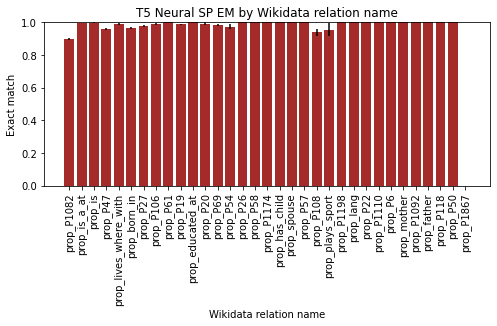

In [313]:

prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][100].T[breakdown_cols]

means = []
stds = []

for score in [prop_scores[a] for a in breakdown_cols]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.figure(figsize=(8,3))
plt.xticks(rotation=90)
plt.title("T5 Neural SP EM by Wikidata relation name")
plt.ylabel("Exact match")
plt.xlabel("Wikidata relation name")

plt.bar(breakdown_cols,means,yerr=stds, color="brown")
plt.ylim(0,1)
plt.savefig("/scratch/jth/neural_sp_rels.pdf", bbox_inches = 'tight')
plt.show()


In [314]:
prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][100.0].T[a_type_cols]

means = []
stds = []

sort_cols = sorted(a_type_cols)
for score in [prop_scores[a] for a in sort_cols]:
    means.append(score["mean"])
    stds.append(score["std"])


plt.figure(figsize=(8,4))
plt.xticks(rotation=90)

plt.title("T5 Neural SP EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.bar(sort_cols,means,yerr=stds, color="brown")
plt.ylim(0,1)
print(means)
print(stds)
plt.savefig("/scratch/jth/neural_sp_proj.pdf", bbox_inches = 'tight')
plt.show()

KeyError: 'A_type_argmax'

In [72]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")
plt.title("T5 Operator model negative instance EM by negative type")

x = np.arange(len(type_cols2))
w = 0.2
plt.xticks(x+w/5, type_cols2,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

    means = []
    stds = []

    for score in [prop_scores[a] for a in type_cols2]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

plt.ylim(0,1)
plt.legend(datasets)
plt.show()

KeyError: 'null'

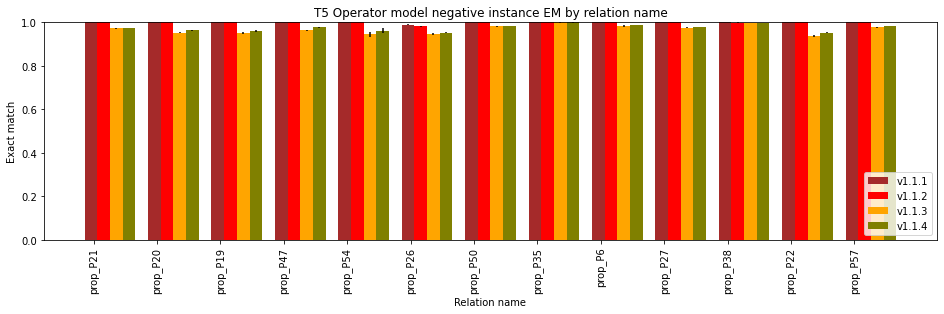

In [64]:

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by relation name")
plt.ylabel("Exact match")
plt.xlabel("Relation name")
plt.title("T5 Operator model negative instance EM by relation name")

x = np.arange(len(breakdown_cols))
w = 0.2
plt.xticks(x+w/5, breakdown_cols,rotation=90)

datasets = ["v1.1.1", "v1.1.2", "v1.1.3", "v1.1.4"]
colors = ["brown", "red","orange", "olive"]
for idx, display in enumerate(datasets):
    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[breakdown_cols]

    means = []
    stds = []

    for score in [prop_scores[a] for a in breakdown_cols]:
        means.append(score["mean"])
        stds.append(score["std"])

    plt.bar(x+idx*w,means,yerr=stds, width=w, color=colors[idx])

print(means)
plt.ylim(0,1)
plt.legend(datasets, loc='lower right')
plt.show()


In [ ]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("T5 Operator model EM by projection type")
plt.ylabel("Exact match")
plt.xlabel("Projection type")


prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["null"][100.0].T[type_cols2]

means = []
stds = []

for score in [prop_scores[a] for a in type_cols2]:
    means.append(score["mean"])
    stds.append(score["std"])

plt.bar(type_cols2,means,yerr=stds)

plt.ylim(0,1)
plt.show()




In [112]:
prop_scores = breakdown.T["operator_sweep"]["t5-base"]["null"][100.0].T[type_cols3]

means = []
stds = []
matched = []
props = []

w = 0.3
for name in type_cols3:

    try:
        score =  prop_scores[name]
        matched.append(name)
        means.append(score["mean"])
        stds.append(score["std"])

    except:
        print("No instances for {}".format(name))

    if "x" not in name:
        props.append(breakdown.T["operator_sweep"]["t5-base"]["null"][100.0]["count_{}".format(name)]["amax"])
    else:
        props.append(0.0)


fig,ax1 = plt.subplots(figsize=(16,4))

x = np.arange(len(matched))

plt.xticks(x+w/2, matched,rotation=90)
plt.title("T5 Operator model negative instance EM by negative type")
ax1.set_ylabel("Exact match")
ax1.set_xlabel("Projection type")

ems = ax1.bar(x, means, yerr=stds, width=w)

ax2 = plt.twinx()
sizes = ax2.bar(x+w, props, color="orange", width=w)
ax1.set_ylabel("Number of data")

plt.legend([ems,sizes],['EM Score','Number of data'])
ax1.set_ylim(0,1)
ax2.set_ylim(0,600)
plt.show()

KeyError: 't5-base'

In [277]:
breakdown_cols= list(filter(lambda col: col!= "P27" and col!="prop_P27",breakdown_cols))
print(breakdown_cols)
cols2 = list(set(map(lambda a: a[0], filter(lambda col:col[0] != "null", breakdown.T["operator_filter"]["v1.1.1"]["t5-base"]["1e-4"].columns))))

x_labels = sorted(cols2)
y_labels = sorted(breakdown_cols)

heatmap = []

for c in y_labels:
    row = []
    for x in x_labels:
        row.append(breakdown.T["operator_filter"]["v1.3.1"]["t5-base"]["1e-4"][x][100.0].T[c]["mean"])
    heatmap.append(row)

heatmap=np.array(heatmap)

assert heatmap.shape[0] == len(y_labels)
assert heatmap.shape[1] == len(x_labels)

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(1-heatmap, cmap="YlOrBr")

fig.tight_layout()
plt.xticks(np.arange(len(x_labels)),x_labels,rotation=90)
plt.yticks(np.arange(len(y_labels)),y_labels)

for j in range(len(x_labels)):
    for i in range(len(y_labels)):
        text = ax.text(j,i, round(100*(1-heatmap[i,j]),1),color='w', ha="center",va="center")


plt.xlabel("Property removed at training")
plt.ylabel("Property error rate at test time")
plt.title("Error rates (%) for cross domain transfer between relations")
plt.savefig("/scratch/jth/neural_sp_trans.pdf", bbox_inches = 'tight')
plt.show()


['prop_P106', 'prop_P20', 'prop_P1082', 'prop_P19', 'prop_P47', 'prop_P1110', 'prop_educated_at', 'prop_is', 'prop_born_in', 'prop_P21', 'prop_is_a_at', 'prop_P69', 'prop_lang', 'prop_P61', 'prop_P54', 'prop_P26', 'prop_lives_where_with', 'prop_P58', 'prop_P22', 'prop_P108', 'prop_P6', 'prop_plays_sport', 'prop_father', 'prop_spouse', 'prop_P1092', 'prop_has_child', 'prop_mother', 'prop_P118', 'prop_P1198', 'prop_P57', 'prop_P50', 'prop_P35', 'prop_P38', 'prop_P1174', 'prop_P1867']


KeyError: 'operator_filter'

('operator_filter', 'v1.3.2', 't5-base', '8e-5', 'P106', 100.0)
[1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 100.0]


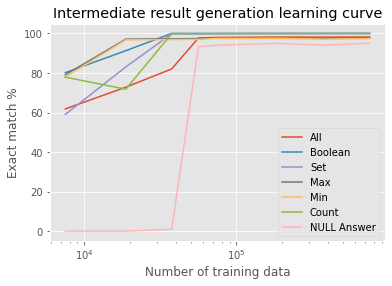

In [15]:
import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    print(breakdown.index[0])
    display = "v1.3.2"
    sizes = [a[5] for a in breakdown.index if a[1] == display and a[3] == "8e-5" and a[4] == "null" and a[5] != "null"]
    print(sizes)

    prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][sizes].T["EM"]

    means = []
    uppers = []
    lowers = []

    for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
        means.append(mean*100)
        lowers.append((mean-std)*100)
        uppers.append((mean-std)*100)


    plt.figure(figsize=(6,4))

    actual = [750000*size/100 for size in sizes]
    plt.title("Intermediate result generation learning curve")
    plt.ylabel("Exact match %")
    plt.xlabel("Number of training data")

    plt.plot(actual,means)
    plt.fill_between(actual,lowers,uppers,alpha=0.2)
    plt.xscale("log")

    labels = {
        "type_count": "Count",
        "type_set": "Set",
        "type_argmin": "Min",
        "type_argmax": "Max",
        "type_bool":"Boolean",
        "type_ext": "Extractive",
        "x_avg_negative": "NULL Answer"
    }

    legend = ["All"]
    for line in type_cols2:
         prop_scores = breakdown.T["operator_sweep"][display]["t5-base"]["8e-5"]["null"][sizes].T[line]
         means = []
         uppers = []
         lowers = []

         for mean,std in [(prop_scores["mean"][size],prop_scores["std"][size]) for size in sizes]:
             means.append(100*mean)
             lowers.append(100*(mean-std))
             uppers.append(100*(mean-std))


         plt.plot(actual,means)
         plt.fill_between(actual,lowers,uppers,alpha=0.2)
         legend.append(labels[line])



    plt.legend(legend)
    plt.savefig("/scratch/jth/neural_sp_data.pdf", bbox_inches = 'tight')
    plt.show()


In [ ]:
    def get_num(item):
        bits = item.split("[SEP]")
        if len(bits) > 1:
            return bits[1].strip()
        else:
            return None

    def get_ent(item):
        bits = item.split("[SEP]")
        if len(bits) > 1:
            return bits[0].strip().replace("[LOOKUP]","").strip()
        else:
            return None

    err_predict_null =0
    err_wrong_num = 0
    err_wrong_ent = 0

    for exp in filter(lambda exp: "filters=null,train_percentage=1.0" in exp["file"], experiments):
        for item in exp["raw"]:
            if "[SEP]" in item[0]:
                master = get_num(item[0])
                predicted = get_num(item[1])

                if predicted is None:
                    err_predict_null += 1

                elif predicted != master:
                    err_wrong_num += 1

                    print(predicted,master)

            if "[SEP]" in item[0]:
                master = get_ent(item[0])
                predicted = get_ent(item[1])

                if predicted is None:
                    pass
                elif predicted != master:
                    err_wrong_num += 1
                    print(predicted,master)


    print(err_wrong_num, err_predict_null)

In [306]:
import random
from collections import defaultdict

print("LABEL")
type_counts = defaultdict(int)
for exp in experiments:
    if exp["version"] == "v2.2" and exp["lr"] == "8e-5" and exp["train_percentage"]==100:
        for item in exp["raw"]:
            if item[0].split(" ")[0] != item[1].split(" ")[0]:
                test_instance = item[3]
                if test_instance["type"]!="negative":
                    print(item[0])
                    print(item[1])
                type_counts[test_instance["type"]] +=1



        break


print(type_counts)



LABEL
[BOOL] Itzcoatl
[SET] Itzcoatl
[NULL_ANSWER]
[ARG] king of Wisigoths [SEP] Gundemar
[BOOL] FALSE
[NULL_ANSWER]
[BOOL] FALSE
[NULL_ANSWER]
[BOOL] FALSE
[NULL_ANSWER]
defaultdict(<class 'int'>, {'negative': 214, 'set': 1, 'argmin': 1, 'atomic_boolean': 2, 'atomic_extractive': 1})


In [293]:
from collections import defaultdict

print("FALSE NEGATIVES")
type_counts = defaultdict(int)
for exp in experiments:
    if exp["version"] == "v2.2" and exp["lr"] == "8e-5" and exp["train_percentage"]==100:
        for item in exp["raw"]:
        # for item in random.sample(exp["raw"],k=100):
            if "[NULL_ANSWER]" in item[0] and item[2]<1:
                test_instance = item[3]
                type_counts[test_instance["type"]] +=1
                #print("*"*80)
                #print("Score\t\t",item[2])
                #print("Query\t\t",item[3]["query"])
                #print("Fact\t\t",item[3]["fact"])
                #print("Projection\t\t",item[3]["projection"])
                ##print("Projection (tokenized)\t\t", item[1])
                #print("Predicted (tokenized)\t\t", item[0])

print(type_counts)

FALSE NEGATIVES
defaultdict(<class 'int'>, {'argmin': 1})


In [303]:
import random
from collections import defaultdict


print("FALSE POSITIVES")
type_counts = defaultdict(int)
for exp in experiments:
    if exp["version"] == "v2.2" and exp["lr"] == "8e-5" and exp["train_percentage"]==100:
        for item in exp["raw"]:
            if "[NULL_ANSWER]" in item[1] and item[2]<1:
                test_instance = item[3]
                type_counts[test_instance["type"]] +=1
                print("*"*80)
                print("Score\t\t",item[2])
                print("Query\t\t",item[3]["query"])
                print("Type\t\t",item[3]["type"])
                print("Fact\t\t",item[3]["fact"])
                print("Projection\t\t",item[3]["projection"])
                print("Projection (tokenized)\t\t", item[1])
                print("Predicted (tokenized)\t\t", item[0])


        break


print(type_counts)

FALSE POSITIVES
********************************************************************************
Score		 0.0
Query		 Who has been to the fewest universities?
Type		 negative
Fact		 ['Jacques Attali did their undergraduate at Sciences Po']
Projection		 None
Projection (tokenized)		 [NULL_ANSWER]
Predicted (tokenized)		 [ARG] Jacques Attali [SEP] Sciences Po
********************************************************************************
Score		 0.0
Query		 Who has had the least number of jobs?
Type		 negative
Fact		 ['Xuxa works as a television actor']
Projection		 None
Projection (tokenized)		 [NULL_ANSWER]
Predicted (tokenized)		 [ARG] Xuxa [SEP] television actor
********************************************************************************
Score		 0.0
Query		 Which place has the smallest population?
Type		 negative
Fact		 ['There are 2246 inhabitants of Storvik']
Projection		 None
Projection (tokenized)		 [NULL_ANSWER]
Predicted (tokenized)		 [ARG] Storvik [SEP] 2246
**************

In [301]:
import random
from collections import defaultdict

print("TRANS ERROR")
type_counts = defaultdict(int)
for exp in experiments:
    if exp["version"] == "v2.2" and exp["lr"] == "8e-5" and exp["train_percentage"]==100:
        for item in exp["raw"]:
            if "[NULL_ANSWER]" not in item[0]  and "[NULL_ANSWER]" not in item[1] and item[2]<1:
                test_instance = item[3]
                type_counts[test_instance["type"]] +=1
                print("*"*80)
                print("Score\t\t",item[2])
                print("Query\t\t",item[3]["query"])
                print("Type\t\t",item[3]["type"])
                print("Fact\t\t",item[3]["fact"])
                print("Projection\t\t",item[3]["projection"])
                print("Projection (tokenized)\t\t", item[1])
                print("Predicted (tokenized)\t\t", item[0])


        break


print(type_counts)




TRANS ERROR
********************************************************************************
Score		 0.30000000000000004
Query		 What is the place with the maximum number of borders?
Type		 argmax
Fact		 ['Noyelles-en-Chaussée and Yvrench share borders with each other.']
Projection		 Yvrench [SEP] Noyelles-en-Chaussée
Projection (tokenized)		 [ARG] Yvrench [SEP] Noyelles-en-Chaussée
Predicted (tokenized)		 [ARG] Noyelles-en-Chaussée [SEP] Yvrench
********************************************************************************
Score		 0.2682926829268293
Query		 Which place has the lowest number of neighbours?
Type		 argmin
Fact		 ['Marchéville-en-Woëvre and Maizeray are neighbours.']
Projection		 Maizeray [SEP] Marchéville-en-Woëvre
Projection (tokenized)		 [ARG] Maizeray [SEP] Marchéville-en-Wovre
Predicted (tokenized)		 [ARG] Marchéville-en-Wovre [SEP] Maizeray
********************************************************************************
Score		 0.6296296296296297
Query		 What is t